In [1]:
!pip install tensorflow[and-cuda]==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 64.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 56.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 20.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 12.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [2]:
# To make sure we are using gpu not cpu
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2024-09-18 15:18:26.640079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 15:18:26.640147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 15:18:26.641700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, EarlyStopping

from sklearn.metrics import classification_report,confusion_matrix

In [4]:
tf.__version__

'2.15.1'

In [10]:
import keras
keras.__version__

'2.15.0'

In [5]:
datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
train = datagen.flow_from_directory('/kaggle/input/breast-mammography-private/train', target_size=(224, 224), class_mode='binary', batch_size=256)
# load and iterate validation dataset
# val = datagen.flow_from_directory('/kaggle/input/breast-mammography-ori/public/val', target_size=(224, 224), class_mode='binary', batch_size=16)
# load and iterate test dataset
test = datagen.flow_from_directory('/kaggle/input/breast-mammography-private/test', target_size=(224, 224), class_mode='binary', batch_size=8)

Found 3132 images belonging to 2 classes.
Found 131 images belonging to 2 classes.


In [7]:
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = test.n//test.batch_size

In [8]:
steps = test.n//test.batch_size

test.reset()
X_test, y_test = [], []
for i in range(steps+1):
    a , b = test.next()
    X_test.extend(a) 
    y_test.extend(b)

In [9]:
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape, y_test.shape)

(131, 224, 224, 3) (131,)


In [47]:
from keras.applications import DenseNet121, Xception, EfficientNetB1, EfficientNetB0, MobileNetV2

In [69]:
def get_compiled_model():
    backbone2 = MobileNetV2(input_shape = (224, 224, 3), include_top=False, weights='imagenet')
    backbone2.trainable = False

    print(backbone2.summary())
    VGG_model_2 = Sequential()
    VGG_model_2.add(backbone2)
    VGG_model_2.add(GlobalAveragePooling2D()) #GlobalAveragePooling2D
    VGG_model_2.add(Dense(128, activation='relu'))
    VGG_model_2.add(BatchNormalization())
    VGG_model_2.add(Dropout(0.5))
    VGG_model_2.add(Dense(1, activation='sigmoid'))
    
    VGG_model_2.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy']
        )
    
    return VGG_model_2
    

In [70]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


In [71]:
with strategy.scope():

    model = get_compiled_model()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_9[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [72]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_8  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                      

In [73]:
history = model.fit(train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=30)


Epoch 1/30
12/12 [==============================] - 17s 906ms/step - loss: 0.8741 - accuracy: 0.5633 - val_loss: 0.5215 - val_accuracy: 0.8359
Epoch 2/30
12/12 [==============================] - 12s 983ms/step - loss: 0.6882 - accuracy: 0.6620 - val_loss: 0.4319 - val_accuracy: 0.8516
Epoch 3/30
12/12 [==============================] - 12s 970ms/step - loss: 0.5725 - accuracy: 0.7319 - val_loss: 0.3934 - val_accuracy: 0.8672
Epoch 4/30
12/12 [==============================] - 12s 984ms/step - loss: 0.5174 - accuracy: 0.7528 - val_loss: 0.3673 - val_accuracy: 0.8750
Epoch 5/30
12/12 [==============================] - 13s 1s/step - loss: 0.4754 - accuracy: 0.7803 - val_loss: 0.3560 - val_accuracy: 0.8750
Epoch 6/30
12/12 [==============================] - 12s 975ms/step - loss: 0.4508 - accuracy: 0.7942 - val_loss: 0.3333 - val_accuracy: 0.8906
Epoch 7/30
12/12 [==============================] - 13s 1s/step - loss: 0.4359 - accuracy: 0.7988 - val_loss: 0.3280 - val_accuracy: 0.8906
Epoch

In [74]:
score2 = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score2[0]} / Test accuracy: {score2[1]}')

Test loss: 0.19370795786380768 / Test accuracy: 0.9389312863349915


In [75]:
y_pred_prob_3 = model.predict(X_test)

5/5 [==============================] - 1s 22ms/step


In [76]:
threshold = 0.5
y_pred_3 = np.where(y_pred_prob_3 > threshold, 1,0)
y_pred_3.squeeze()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

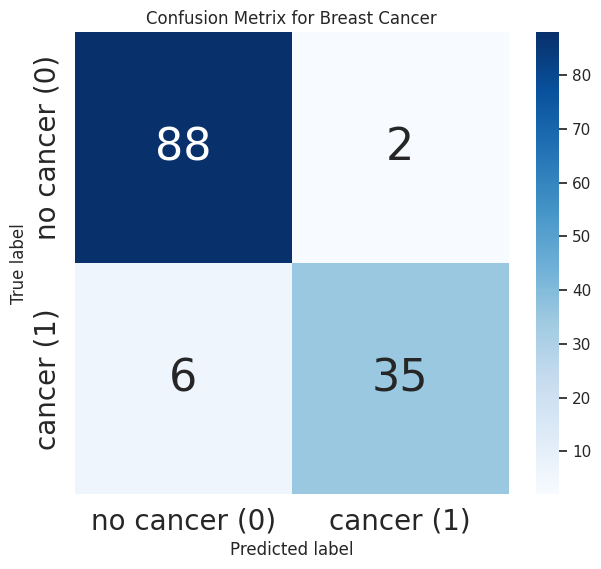

In [77]:
sns.set(rc={'figure.figsize':(7, 6)})

sns.heatmap(confusion_matrix(y_test,y_pred_3),cmap=plt.cm.Blues,annot=True,annot_kws={"size": 32}, fmt='g')
plt.xticks([0.50,1.50], ['no cancer (0)','cancer (1)'], fontsize=20)
plt.yticks([0.50,1.50],['no cancer (0)','cancer (1)'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.title('Confusion Metrix for Breast Cancer')

In [78]:
print(classification_report(y_test, y_pred_3, target_names = ['No cancer (Class 0)','cancer (Class 1)']))

                     precision    recall  f1-score   support

No cancer (Class 0)       0.94      0.98      0.96        90
   cancer (Class 1)       0.95      0.85      0.90        41

           accuracy                           0.94       131
          macro avg       0.94      0.92      0.93       131
       weighted avg       0.94      0.94      0.94       131

